In [40]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf



In [41]:
disease_types=['COVID', 'non-COVID']
data_dir = ''
train_dir = os.path.join(data_dir)

In [42]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [43]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [44]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [03:13, 12.82it/s]

(2481, 64, 64, 3)


In [45]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [76]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(input = vgg16_model.input, output = predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [77]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [78]:
training_datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)
training_datagen.fit(X_train)


history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=200,
                              validation_data=(X_val, Y_val),validation_steps=50)

Epoch 1/200
100/100 [==============================] - 7s 73ms/step - loss: 1.0519 - accuracy: 0.5811 - val_loss: 0.6085 - val_accuracy: 0.6707
Epoch 2/200
100/100 [==============================] - 7s 68ms/step - loss: 0.8985 - accuracy: 0.6288 - val_loss: 0.5787 - val_accuracy: 0.6948
Epoch 3/200
100/100 [==============================] - 7s 67ms/step - loss: 0.8395 - accuracy: 0.6488 - val_loss: 0.5764 - val_accuracy: 0.6988
Epoch 4/200
100/100 [==============================] - 7s 68ms/step - loss: 0.8005 - accuracy: 0.6642 - val_loss: 0.5804 - val_accuracy: 0.6908
Epoch 5/200
100/100 [==============================] - 7s 67ms/step - loss: 0.7706 - accuracy: 0.6747 - val_loss: 0.5817 - val_accuracy: 0.7028
Epoch 6/200
100/100 [==============================] - 7s 67ms/step - loss: 0.7472 - accuracy: 0.6760 - val_loss: 0.5827 - val_accuracy: 0.6908
Epoch 7/200
100/100 [==============================] - 7s 67ms/step - loss: 0.7311 - accuracy: 0.6790 - val_loss: 0.5889 - val_accuracy:

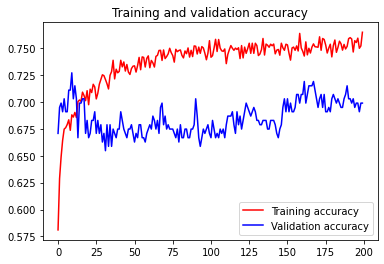

<Figure size 432x288 with 0 Axes>

In [80]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()